In [1]:
import torch
print(torch.cuda.is_available())

True


# Class

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ------------------------------
# Custom Truncated Normal Initialization
# ------------------------------
def truncated_normal_(tensor, mean=0.0, std=0.2, a=-2.0, b=2.0):
    """
    Custom truncated normal initialization.
    This method ensures values stay within the range [a, b].
    """
    lower, upper = (a - mean) / std, (b - mean) / std
    tensor.data = torch.distributions.Normal(mean, std).rsample(tensor.shape)
    tensor.data = torch.clip(tensor.data, min=a, max=b)
    return tensor

# ------------------------------
# Input Embedding Module (CNN-Based)
# ------------------------------
class InputEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim=256, kernel_sizes=[4, 3], strides=[2, 2]):
        super(InputEmbedding, self).__init__()
        
        self.conv1 = nn.Conv1d(input_dim, embed_dim, kernel_sizes[0], stride=strides[0])
        self.bn1 = nn.BatchNorm1d(embed_dim)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(embed_dim, embed_dim, kernel_sizes[1], stride=strides[1])
        self.bn2 = nn.BatchNorm1d(embed_dim)

        self.cls_token = nn.Parameter(truncated_normal_(torch.empty(1, 1, embed_dim)))
        self.pos_embedding = nn.Parameter(truncated_normal_(torch.empty(1, embed_dim + 1, embed_dim)))

    def forward(self, x):
        """
        x: (batch_size, channels, time_steps)
        Output: (batch_size, seq_len+1, embed_dim)
        """
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))

        x = x.permute(0, 2, 1)  # Reshape for transformer (batch_size, seq_len, embed_dim)

        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embedding[:, :x.shape[1], :]

        return x

# ------------------------------
# Multi-Head Self-Attention
# ------------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape

        qkv = self.qkv_proj(x)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        return self.out_proj(attn_output)

# ------------------------------
# Feed-Forward Network (MLP Block)
# ------------------------------
class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim, ffn_dim, ffn_dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ffn_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(ffn_dim, embed_dim)
        self.dropout = nn.Dropout(ffn_dropout)

    def forward(self, x):
        return self.dropout(self.fc2(self.gelu(self.fc1(x))))

# ------------------------------
# DropPath (Stochastic Depth)
# ------------------------------
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        random_tensor = keep_prob + torch.rand(x.shape, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

# ------------------------------
# Transformer Block
# ------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=16, ffn_dim=1024, drop_path_rate=0.1, attn_dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout)
        self.drop_path1 = DropPath(drop_path_rate)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForwardNetwork(embed_dim, ffn_dim)
        self.drop_path2 = DropPath(drop_path_rate)

    def forward(self, x, mask=None):
        x = x + self.drop_path1(self.attn(self.norm1(x), mask))
        x = x + self.drop_path2(self.ffn(self.norm2(x)))
        return x

# ------------------------------
# Transformer Encoder
# ------------------------------
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=256, num_blocks=4, num_heads=16, ffn_dim=1024, drop_path_rate=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ffn_dim, drop_path_rate)
            for _ in range(num_blocks)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

# ------------------------------
# SOH-TEC Model
# ------------------------------
class SOHTEC(nn.Module):
    def __init__(self, input_dim=5, embed_dim=256, num_blocks=4, num_heads=16, ffn_dim=1024, drop_path_rate=0.1):
        super(SOHTEC, self).__init__()

        self.embedding = InputEmbedding(input_dim, embed_dim)
        self.encoder = TransformerEncoder(embed_dim, num_blocks, num_heads, ffn_dim, drop_path_rate)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Linear(embed_dim // 2, 1)  # Regression output for SOH estimation
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        return self.mlp_head(x[:, 0])  # Using CLS token for SOH prediction


# Battery

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("data/battery/scaledData1_with_soh.csv")

features = ['pack_voltage (V)', 'charge_current (A)', 'max_temperature (℃)', 'min_temperature (℃)', 'soc']
X = df[features].values

y = df["soh (%)"].values if "soh (%)" in df.columns else None

scaler_data = StandardScaler()
X = scaler_data.fit_transform(X)
y = y / 100

SEQ_LEN = 100
NUM_FEATURES = len(features)

def create_sequences(X, y, seq_len):
    sequences = []
    targets = []
    
    for i in range(0, len(X) - seq_len, seq_len):
        sequences.append(X[i:i+seq_len])
        if y is not None:
            targets.append(y[i+seq_len-1])
    
    return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

train_size = int(0.8 * len(X_seq))
val_size = int(0.1 * len(X_seq))
test_size = len(X_seq) - train_size - val_size

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

class SOHDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).permute(0, 2, 1)
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SOHDataset(X_train, y_train)
val_dataset = SOHDataset(X_val, y_val)
test_dataset = SOHDataset(X_test, y_test)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)  # No shuffle to preserve sequence order
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SOHTEC(input_dim=NUM_FEATURES, embed_dim=256).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                val_loss += criterion(outputs, batch_y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_soh_tec_model.pth")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20: Train Loss: 0.0182, Val Loss: 0.0015
Epoch 2/20: Train Loss: 0.0023, Val Loss: 0.0004
Epoch 3/20: Train Loss: 0.0016, Val Loss: 0.0006
Epoch 4/20: Train Loss: 0.0013, Val Loss: 0.0004
Epoch 5/20: Train Loss: 0.0012, Val Loss: 0.0005
Epoch 6/20: Train Loss: 0.0009, Val Loss: 0.0005
Epoch 7/20: Train Loss: 0.0009, Val Loss: 0.0005
Epoch 8/20: Train Loss: 0.0008, Val Loss: 0.0005
Epoch 9/20: Train Loss: 0.0008, Val Loss: 0.0003
Epoch 10/20: Train Loss: 0.0007, Val Loss: 0.0004
Epoch 11/20: Train Loss: 0.0006, Val Loss: 0.0003
Epoch 12/20: Train Loss: 0.0006, Val Loss: 0.0003
Epoch 13/20: Train Loss: 0.0006, Val Loss: 0.0002
Epoch 14/20: Train Loss: 0.0005, Val Loss: 0.0002
Epoch 15/20: Train Loss: 0.0005, Val Loss: 0.0002
Epoch 16/20: Train Loss: 0.0005, Val Loss: 0.0002
Epoch 17/20: Train Loss: 0.0006, Val Loss: 0.0001
Epoch 18/20: Train Loss: 0.0005, Val Loss: 0.0001
Epoch 19/20: Train Loss: 0.0005, Val Loss: 0.0001
Epoch 20/20: Train Loss: 0.0005, Val Loss: 0.0001


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, test_loader):
    
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    return rmse, mae, r2

# Evaluate model
model.load_state_dict(torch.load("best_soh_tec_model.pth"))
rmse, mae, r2 = evaluate_model(model, test_loader)


Test RMSE: 0.0182
Test MAE: 0.0154
Test R²: -13.2409


In [6]:
import copy

#### Pruning

In [7]:
import torch.nn.utils.prune as prune

def apply_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

model_pruned = copy.deepcopy(model)
model_pruned = apply_pruning(model_pruned, amount=0.1)
rmse_p, mae_p, r2_p = evaluate_model(model_pruned, test_loader)

Test RMSE: 0.0168
Test MAE: 0.0136
Test R²: -11.2522


#### Distillation

In [8]:
def train_student_model(teacher_model, student_model, train_loader, criterion, criterion_kd, optimizer, alpha=0.5, T=3.0):
    teacher_model.eval()
    student_model.train()

    device = next(teacher_model.parameters()).device  # Get model device
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move inputs to the same device as model

        optimizer.zero_grad()

        with torch.no_grad():
            soft_targets = torch.softmax(teacher_model(batch_X) / T, dim=1)  # Ensure input is on the same device

        student_output = student_model(batch_X)  # Ensure input is on the same device
        loss_hard = criterion(student_output, batch_y)
        loss_soft = criterion_kd(torch.log_softmax(student_output / T, dim=1), soft_targets)

        loss = alpha * loss_hard + (1 - alpha) * loss_soft
        loss.backward()
        optimizer.step()

    return student_model

student_model = SOHTEC(input_dim=NUM_FEATURES, embed_dim=128).to(device)
criterion = nn.MSELoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.AdamW(student_model.parameters(), lr=5e-5, weight_decay=1e-4)
student_model = train_student_model(model, student_model, train_loader, criterion, criterion_kd, optimizer)

rmse_d, mae_d, r2_d = evaluate_model(student_model, test_loader)

C:\Users\serha\PycharmProjects\Temp\.venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test RMSE: 0.0417
Test MAE: 0.0359
Test R²: -74.2847


C:\Users\serha\PycharmProjects\Temp\.venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#### Quantization

In [9]:
def apply_quantization(model):
    model.cpu()  # Move model to CPU since dynamic quantization only works on CPU
    quantized_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )
    return quantized_model

def evaluate_model(model, test_loader, use_gpu=True):
    
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            if use_gpu:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    return rmse, mae, r2

model_quantized = copy.deepcopy(model)
model_quantized = apply_quantization(model_quantized)
rmse_q, mae_q, r2_q = evaluate_model(model_quantized, test_loader, use_gpu=False)

Test RMSE: 0.0178
Test MAE: 0.0151
Test R²: -12.7540


## Results

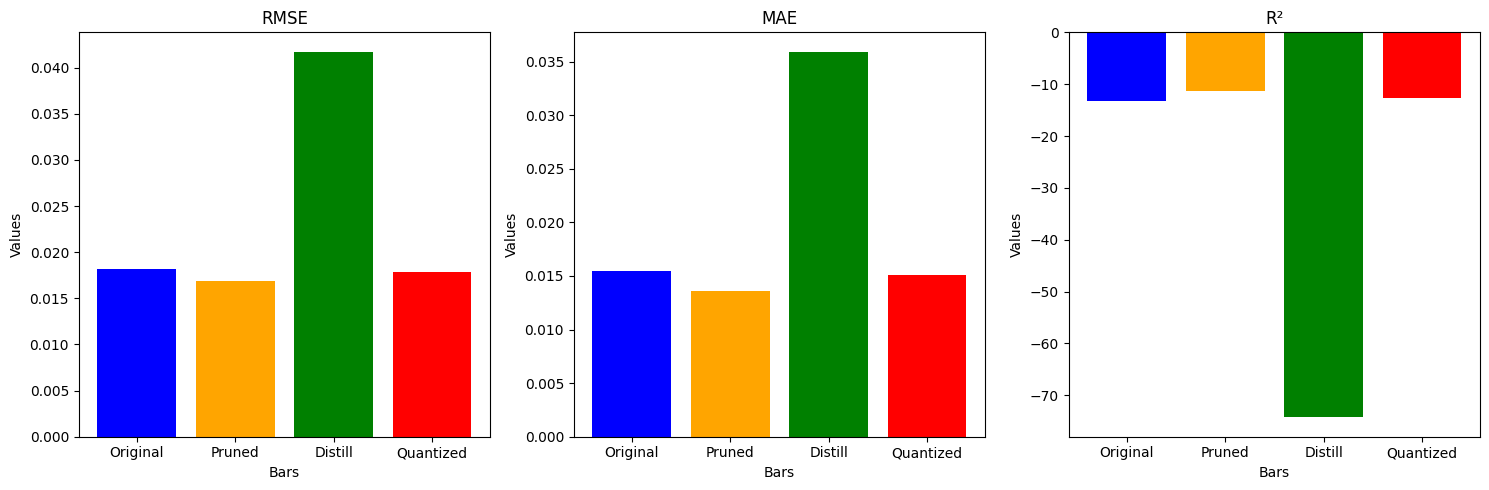

In [10]:
import matplotlib.pyplot as plt

values = np.array([[rmse, rmse_p, rmse_d, rmse_q],
                   [mae , mae_p , mae_d , mae_q],
                   [r2  , r2_p  , r2_d  , r2_q]])

bar_labels = ['Original', 'Pruned', 'Distill', 'Quantized']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# RMSE Plot
ax_rmse = axes[0]
ax_rmse.bar(bar_labels, values[0], color=['blue', 'orange', 'green', 'red'])
ax_rmse.set_title("RMSE")
ax_rmse.set_ylabel("Values")
ax_rmse.set_xlabel("Bars")

# MAE Plot
ax_mae = axes[1]
ax_mae.bar(bar_labels, values[1], color=['blue', 'orange', 'green', 'red'])
ax_mae.set_title("MAE")
ax_mae.set_ylabel("Values")
ax_mae.set_xlabel("Bars")

# R2 Plot
ax_r2 = axes[2]
ax_r2.bar(bar_labels, values[2], color=['blue', 'orange', 'green', 'red'])
ax_r2.set_title("R²")
ax_r2.set_ylabel("Values")
ax_r2.set_xlabel("Bars")

# Adjust layout and display
plt.tight_layout()
plt.show()


#### Monitoring

In [11]:
import subprocess, threading, time, psutil

monitoring = True

def monitor_idle_gpu_cpu(duration=10, interval=1):
    
    power_values = []
    gpu_util_values = []
    cpu_util_values = []
    memory_used_values = []
    
    start_time = time.time()
    
    while time.time() - start_time < duration:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=power.draw,utilization.gpu,memory.used", "--format=csv,noheader,nounits"],
            capture_output=True, text=True
        )
        
        power, gpu_util, memory_used = map(float, result.stdout.strip().split(", "))
        cpu_util = psutil.cpu_percent(interval=0.1)
        
        power_values.append(power)
        gpu_util_values.append(gpu_util)
        cpu_util_values.append(cpu_util)
        memory_used_values.append(memory_used)
        
        time.sleep(interval)
    
    avg_power = sum(power_values) / len(power_values)
    avg_gpu_util = sum(gpu_util_values) / len(gpu_util_values)
    avg_cpu_util = sum(cpu_util_values) / len(cpu_util_values)
    memory_used_max = max(memory_used_values)
    
    return avg_power, avg_gpu_util, avg_cpu_util, memory_used_max

def monitor_gpu(log_file = 'gpu_usage_log.csv', interval = 1):

    query_params = [
        "timestamp", "power.draw", "memory.used", "memory.total",
        "utilization.gpu", "utilization.memory", "temperature.gpu",
        "fan.speed", "clocks.sm", "clocks.gr"
    ]
    
    query_str = ",".join(query_params)
    
    with open(log_file, "w") as f:
        f.write("Timestamp,Power (W),Memory Used (MB),Memory Total (MB),GPU Util (%),"
                "Memory Util (%),Temp (C),Fan Speed (%),Clock SM (MHz),Clock Mem (MHz),"
                "CPU Usage (%)\n")
    
    while monitoring:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=" + query_str, "--format=csv,noheader,nounits"],
            capture_output=True, text=True
        )

        gpu_data = list(map(float, result.stdout.strip().split(", ")[1:]))
        gpu_data[0] = gpu_data[0] - avg_power
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
        cpu_usage = psutil.cpu_percent() - avg_cpu_util
        
        log_entry = f"{timestamp}," + ",".join(list(map(str, gpu_data))) + f",{cpu_usage}\n"
        
        with open(log_file, "a") as f:
            f.write(log_entry)

        time.sleep(interval)

In [12]:
avg_time = 10
avg_power, avg_gpu_util, avg_cpu_util, memory_used_max = monitor_idle_gpu_cpu(duration=avg_time)

print(f'\nAverage values over {avg_time} seconds: \nAVG_GPU_POWER = {avg_power}, AVG_GPU_UTIL = {avg_gpu_util}, AVG_CPU_UTIL = {avg_cpu_util}, MAX_MEMORY_UTIL = {memory_used_max}\n')


# Original ===============================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_original.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
_, _, _ = evaluate_model(model, test_loader)
print(f'Original : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

# Pruned =================================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_pruned.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
_, _, _ = evaluate_model(model_pruned, test_loader)
print(f'Pruned : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

# Distill ================================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_distill.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
_, _, _ = evaluate_model(student_model, test_loader)
print(f'Distill : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

# Quantized ==============================================================================================

monitor_thread = threading.Thread(target=monitor_gpu, args=('outputs/log_testing_quantized.csv', 0.01), daemon=True)
monitor_thread.start()

start_time = time.time()
_, _, _ = evaluate_model(model_quantized, test_loader, use_gpu=False)
print(f'Quantized : {time.time()-start_time} seconds\n')

monitoring = False
time.sleep(2)
monitoring = True

Exception in thread Thread-21 (monitor_gpu):
Traceback (most recent call last):
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\serha\PycharmProjects\Temp\.venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\serha\AppData\Local\Temp\ipykernel_48744\3663921341.py", line 58, in monitor_gpu
ValueError: could not convert string to float: '[N/A]'



Average values over 10 seconds: 
AVG_GPU_POWER = 18.0, AVG_GPU_UTIL = 19.444444444444443, AVG_CPU_UTIL = 8.544444444444444, MAX_MEMORY_UTIL = 2884.0

Test RMSE: 0.0182
Test MAE: 0.0154
Test R²: -13.2409
Original : 0.1866283416748047 seconds



Exception in thread Thread-24 (monitor_gpu):
Traceback (most recent call last):
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\serha\PycharmProjects\Temp\.venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\serha\AppData\Local\Temp\ipykernel_48744\3663921341.py", line 58, in monitor_gpu
ValueError: could not convert string to float: '[N/A]'


Test RMSE: 0.0168
Test MAE: 0.0136
Test R²: -11.2522
Pruned : 0.18201971054077148 seconds



Exception in thread Thread-27 (monitor_gpu):
Traceback (most recent call last):
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\serha\PycharmProjects\Temp\.venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\serha\AppData\Local\Temp\ipykernel_48744\3663921341.py", line 58, in monitor_gpu
ValueError: could not convert string to float: '[N/A]'


Test RMSE: 0.0417
Test MAE: 0.0359
Test R²: -74.2847
Distill : 0.18914151191711426 seconds



Exception in thread Thread-30 (monitor_gpu):
Traceback (most recent call last):
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\serha\PycharmProjects\Temp\.venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\serha\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\serha\AppData\Local\Temp\ipykernel_48744\3663921341.py", line 58, in monitor_gpu
ValueError: could not convert string to float: '[N/A]'


Test RMSE: 0.0178
Test MAE: 0.0151
Test R²: -12.7540
Quantized : 0.4571995735168457 seconds



In [13]:
def save_test_data(test_loader):
    X_test, y_test = [], []
    for batch_X, batch_y in test_loader:
        X_test.append(batch_X)
        y_test.append(batch_y)
    
    X_test = torch.cat(X_test)
    y_test = torch.cat(y_test)
    torch.save({"X": X_test, "y": y_test}, "test_data/test_data.pt")

# Save model
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(model_quantized, "models/quantized_soh_tec_model.pth")
#save_test_data(test_loader)